In [21]:
from scipy.optimize import NonlinearConstraint, minimize, LinearConstraint
import numpy as np
from scipy.special import gamma, factorial
import pandas as pd
import pickle

In [13]:
gamma_list = [0.45, 0.5, 0.55]
delta_list = np.arange(0.55, 1.0, 0.05)

sqp_dict = {}
N = 50
T = 1
X = 0.1
for delta_const in delta_list:
    for gamma_const in gamma_list:
        sqp_dict[(delta_const, gamma_const)] = 0

In [19]:
for (delta_const, gamma_const) in sqp_dict:
    G = np.zeros((N, N))

    def G_ij_upper(i, j):
        return (1 / (1 - gamma_const) * (1 - gamma_const)) * (T / N) ** (2 - gamma_const) \
                * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
                    (i - j - 1) ** (2 - gamma_const)) 

    def G_ii_diagonal():
        return (2 / ((1 - gamma_const) * (2 - gamma_const))) * (T / N) ** (2 - gamma_const)
        
    G_upper = np.fromfunction(G_ij_upper, (N, N))
    G_upper = np.nan_to_num(G_upper, nan = 0.0)
    G_diag = np.repeat(G_ii_diagonal(), N)
    G_diag = np.diag(G_diag)
    G = G_upper.T + G_upper + G_diag

    v_guess = np.repeat(T * X / N, N) ## VWAP

    def gss_guess(t: np.array) -> np.array:
        gamma_1 = gamma((1 + gamma_const)/ 2)
        gamma_2 = gamma(1 + (gamma_const / 2))
        c = (X / N) / (np.sqrt(np.pi) * (T / 2) ** gamma_const * (gamma_1 / gamma_2))
        return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))
    gss_v_0_guess = gss_guess(np.arange(0, 1 + 1 / (N + 1), 1 / (N + 1)))[1:-1]
    def impact_f(v):
        return np.sign(v) * np.abs(v) ** delta_const

    A = G_upper + G_diag / 2

    def expect_cost_compute(v):
        return v @ A @ impact_f(v).T
    
    def total_volume_cons(x):
        return np.sum(x) - N * X / T
    
    cons = {'type':'eq', 'fun': total_volume_cons}
    result_gss = minimize(expect_cost_compute, gss_v_0_guess, method = "SLSQP", constraints=cons, options = {"maxiter" : 1000})
    sqp_dict[(delta_const, gamma_const)] = result_gss

<ipython-input-19-b8b63946fc93>:6: RuntimeWarning: invalid value encountered in power
  * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
<ipython-input-19-b8b63946fc93>:7: RuntimeWarning: invalid value encountered in power
  (i - j - 1) ** (2 - gamma_const))
<ipython-input-19-b8b63946fc93>:24: RuntimeWarning: divide by zero encountered in true_divide
  return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))


In [20]:
sqp_dict

{(0.55,
  0.45):      fun: 0.01013606575767331
      jac: array([0.00315152, 0.00318823, 0.00318062, 0.00298958, 0.00306942,
        0.0033133 , 0.00252477, 0.00327525, 0.0032034 , 0.00307297,
        0.00309484, 0.00329416, 0.00328105, 0.00310307, 0.00310579,
        0.00306825, 0.00329323, 0.00323004, 0.00321481, 0.00305094,
        0.00332419, 0.00301963, 0.00310438, 0.00313437, 0.00329864,
        0.00298353, 0.00318894, 0.0028844 , 0.00322949, 0.00308417,
        0.00315693, 0.00317009, 0.00316566, 0.00307483, 0.00301733,
        0.0031578 , 0.00320032, 0.00329231, 0.00323805, 0.00307929,
        0.00327919, 0.0029693 , 0.00309455, 0.0031971 , 0.00310012,
        0.00313656, 0.00308223, 0.00303779, 0.00326411, 0.0031106 ])
  message: 'Optimization terminated successfully'
     nfev: 12445
      nit: 243
     njev: 243
   status: 0
  success: True
        x: array([-0.04926557, -0.04356815, -0.04229077, -0.04563001, -0.04454471,
        -0.04132617, -0.05924094, -0.04685064, -0.052

<AxesSubplot:>

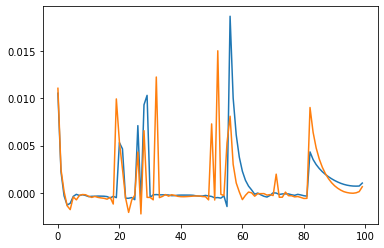

In [50]:
pd.Series(result_vwap.x.astype(np.float)/N).plot()
pd.Series(result_gss.x.astype(np.float)/N).plot()

In [22]:
with open('sqp_record.pickle', 'wb') as handle:
    pickle.dump(sqp_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)